In [43]:
print('Takumi House & Kailen Santos')

Takumi House & Kailen Santos


Our original pitch was the following: <br>
People rarely report cases of food poisoning to the appropriate government bodies. However, they are more likely to post on restaurant review apps like Yelp, sharing their negative experiences. <br>
Our plan is to use the Yelp API to search for key terms like ‘sick’, ‘food poisoning’, ‘nausea’, ‘throw up’ to see if there are any restaurants in the Boston area that have noticeably high-frequency reports of cases of food poisoning. Then, we will cross reference them with the Boston Health Inspection dataset from the Boston Inspectional Services Department see if there are any restaurants that are slipping through the cracks of the health inspectors, and whether or not we can predict at which restaurants patrons are most at risk. We can then see if there are certain locations, or certain kinds of restaurants, that seem to result in higher numbers of food safety infractions. <br>
Our first challenge came with the Yelp API. Due to registration issues and limitations of the API, we realized quickly that the API was not capable of carrying out our proposed project, even though we had data regarding health inspection data from the City of Boston Open Data Portal. We looked into the use of other APIs, like the FourSquare API, which was more user-friendly and could provide us with full text reviews of restaurants. Although the businesses on the FourSquare API had fewer users, and therefore fewer reviews, we were optimistic that we could still make use of the data. We started caching the data information returned by the FourSquare API, but soon realized that, although there was a fair amount of traffic on any given business, the total number of businesses registered on FourSquare were far fewer in number. The FourSquare API also lacks a pagination parameter, which made a complete scrape of Boston's restaurants difficult. <br>
Upon Professor Terzi's recommendation, we turned to the Yelp Academic Dataset. We were hesitant at first to use the Academic Dataset, namely due to the fact that the information is static, and as mentioned on the Yelp Dataset Challenge page, the dataset is made up of \"Only the reviews that Yelp recommended at the time of data collection.\" We were concerned, due to past reports of unfair review filtering on Yelp's part, that this may have meant that there was a bias in the data towards positive reviews. However, upon further inspection, it appears that recommended reviews are reviews that best indicate the average opinion of the business, and would therefore be a good indicator of public opinion. This means that we won't get all of the reviews for every business, but we are hopeful that there are telling reviews within this subset. The dataset was first released in 2013, but was updated most recently in January of 2017. Unlike the API, the Academic Dataset offered full text reviews, which is crucial to the success of our project. We decided to use Las Vegas as our test city because Las Vegas has their own Open Data Portal, where we found a Restaurant Inspections Dataset within their Public Safety Division. Similar to the one found for Boston, it contains restaurants, violations, ensuing consequences, etc. This is perfect for our comparisons. Additionally, Las Vegas has more than twice the number of restaurants than the second most frequent city in the dataset, and more than three times the number of reviews than the second most frequent city in the dataset.

In [48]:
from matplotlib import pyplot as plt
import matplotlib as mp
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import sklearn.manifold
from scipy import cluster
import seaborn as sns
import sklearn.datasets as sk_data
import sklearn.metrics as metrics
import requests
import json
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
import re
import json
import pickle
%matplotlib inline

We begin by cleaning the academic dataset of irrelevant business. We only want too look at restaurants in Las Vegas, so we iterate through all of the json objects and filter out the unneeeded businesses, and add them to a list names.

In [50]:
restaurants = {}
names=[]
with open('yelp_academic_dataset_business.json') as data:
    for i in data:
        d = json.loads(i)
        if (d['city']=='Las Vegas'):
            if ('Restaurants' in d['categories']):
                restaurants[d['business_id']] = {'latitude':d['latitude'], 'longitude':d['longitude'], 'address':d['full_address']}
                names.append(d['name'])
# restaurants

In [52]:
bId = []
long = []
lat = []
address = []

for x, y in restaurants.items():
    bId.append(x)
    long.append((y.get('longitude')))
    lat.append((y.get('latitude')))
    address.append(((y.get('address')).rsplit('\n', 5)[0]).lower())
long = np.array(long)
lat = np.array(lat)

print(long)
print(lat)

[-115.2975877 -115.300544  -115.119277  ..., -115.305973  -115.17677
 -115.1765221]
[ 36.0977765  36.206848   36.011058  ...,  36.191844   36.104605
  36.1130109]


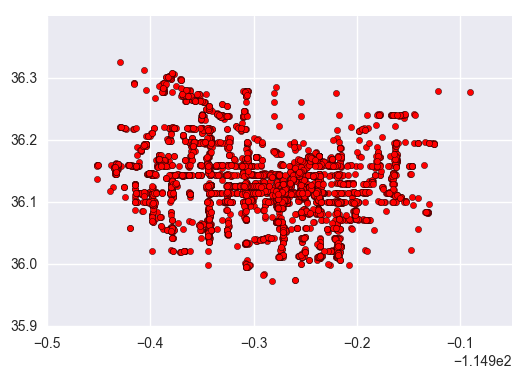

In [54]:
plt.scatter(long, lat, c='red', s=20)

In [56]:
# file = 'Restaurant_Inspections.json'
# data = []
# with open(file) as f:
#     for line in f:
#         data.append(json.loads(line))

We read in the Restaurant Inspections dataset into a pandas dataframe.

In [58]:
df = pd.read_csv('Restaurant_Inspections.csv',header=0)
# df = df[df.City == 'Las Vegas']
# df = (df[df['Inspection Result'] == 'Closed with Fees']).append(df[df['Inspection Result'] == 'Closed without Fees'])

df.shape

#with open ('Resaurant_Inspections.csv') as file:
#   for line in file:
#      if (line[6]=='Las Vegas' && line[]

/Users/takumihouse/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(123919, 23)

We begin cleaning the dataset by checking the cities in which these health inspections took place. Although this dataset is from the Las Vegas Open Data Portal, it contains data from restaurants all around Nevada, as far as 70 miles from the city.
I decide to do this in a step by step process, making sure to check how many lines are removed by every parameter.

In [60]:
df = df[df.City == 'Las Vegas']
df.shape

(94700, 23)

Next, we clean the dataset of health code inspections that do not pertain to restaurants. <br> We define restaurants to be: <br> Places of business open to the public who serve food in exchange for monetary payment. <br> Therefore, we remove the categories that do no adhere to these standards.

In [62]:
categories = df['Category Name'].unique().tolist()
print(categories)

['Pantry', 'Special Kitchen', 'Garde Manger', 'Kitchen Bakery', 'Bar / Tavern', 'Buffet', 'Snack Bar', 'Restaurant', 'Banquet Support', 'Portable Unit', 'Banquet Kitchen', 'Portable Bar', 'Meat/Poultry/Seafood', 'Vegetable Prep', 'Caterer', 'Barbeque', 'Confection', 'Concessions', 'Produce Market', 'Institutional Food Service', 'Elementary School Kitchen', 'Self-Service Food Truck', 'Bakery Sales', 'Food Trucks / Mobile Vendor', 'Grocery Store Sampling', 'Beer Bar', 'Childcare Kitchens', "Farmer's Market", 'Main Kitchen', 'Frozen Meat Sales']


In [64]:
categories.remove('Elementary School Kitchen')
categories.remove('Grocery Store Sampling')
categories.remove('Farmer\'s Market')
categories.remove('Caterer')
categories.remove('Concessions')
categories.remove('Institutional Food Service')
categories.remove('Banquet Support')

In [66]:
df = df[df['Category Name'].isin(categories)]
df.shape

(91735, 23)

In [68]:
coord_strings = df['Location 1'].tolist()

We convert our points from strings to the appropriate float tuple format, and plot our points to see what our spread of inspec looks like.

In [70]:
import ast
xcoords = []
ycoords = []
for coord in coord_strings:
    xcoords.append(ast.literal_eval(coord)[0])
    ycoords.append(ast.literal_eval(coord)[1])

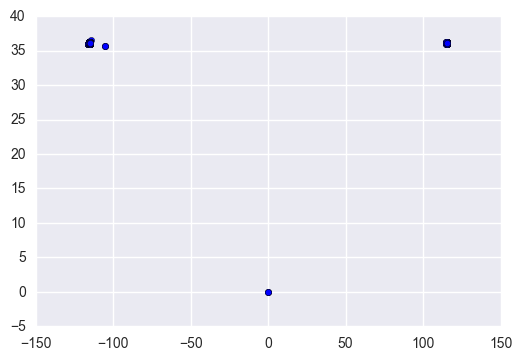

In [72]:
plt.scatter(ycoords, xcoords, c = 'b')

It is evident that there are some outlier coordinates. We aren't certain whether these are due to input errors, or because our cleaning was not sufficient.

Upon further inspection, we realize that some of the y coordinates have erroneously been negated, from ~-115 to ~115. We iterate through the dataset and fix the offending coordinates.

In [74]:
count = 0
for idx, ycoord in enumerate(ycoords):
    if ycoord > 0:
        ycoords[idx] = ycoord * -1
        count += 1
print('{} coordinates fixed.'.format(count))

574 coordinates fixed.


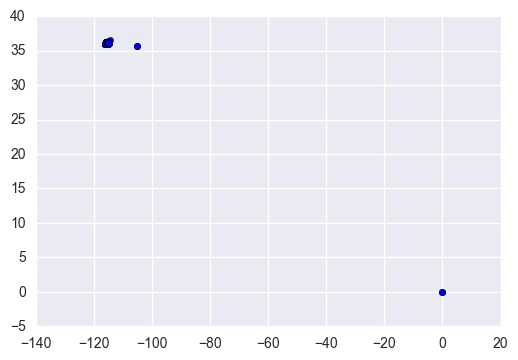

In [76]:
plt.scatter(ycoords, xcoords, c = 'b')

That's better, but it looks like there are a few points at (0,0), likely because coordinate information wasn't provided.

In [78]:
# df = df[df['Location 1'] != '(0, 0)']
df['Coordinates'] = list(zip(xcoords, ycoords))
df.head()

,Serial Number,Permit Number,Restaurant Name,Location Name,Category Name,Address,City,State,Zip,Current Demerits,...,Employee ID,Inspection Type,Inspection Demerits,Inspection Grade,Permit Status,Inspection Result,Violations,Record Updated,Location 1,Coordinates
11,DA0001715,PR0000426,CAESARS AUGUSTUS BUTLER PANTRY,CAESARS PALACE HOTEL & CASINO,Pantry,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,3,...,EE7000417,Routine Inspection,0,A,NaN,Compliant,NaN,02/21/2013 10:26:12 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)"
12,DA0001716,PR0000426,CAESARS AUGUSTUS BUTLER PANTRY,CAESARS PALACE HOTEL & CASINO,Pantry,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,3,...,EE7000567,Routine Inspection,2,A,NaN,Compliant,NaN,02/21/2013 10:26:12 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)"
13,DA0001728,PR0000427,CAESARS DIAMOND LOUNGE KITCHEN,CAESARS PALACE HOTEL & CASINO,Special Kitchen,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,8,...,EE7000417,Routine Inspection,4,A,NaN,Compliant,14,02/21/2013 10:26:12 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)"
14,DA0001773,PR0000434,CAESARS BAKERY WAREWASH,CAESARS PALACE HOTEL & CASINO,Special Kitchen,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,3,...,EE7000417,Routine Inspection,7,A,NaN,Compliant,14232831,01/22/2014 02:03:44 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)"
15,DA0001776,PR0000434,CAESARS BAKERY WAREWASH,CAESARS PALACE HOTEL & CASINO,Special Kitchen,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,3,...,EE7000392,Routine Inspection,2,A,NaN,Compliant,NaN,01/22/2014 02:03:44 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)"


In [80]:
df = df[df['Coordinates'] != (0,0)]
# df = df[df['Coordinates'][1] < -112]
df.shape

(91732, 24)

Creating Series in the df for ease of use when checking coordinate limits.

In [82]:
coordinates_list = df['Coordinates'].tolist()
xcoords = []
ycoords = []
for coordinates in coordinates_list:
    xcoords.append(coordinates[0])
    ycoords.append(coordinates[1])
df['X'] = xcoords
df['Y'] = ycoords
df.head()

,Serial Number,Permit Number,Restaurant Name,Location Name,Category Name,Address,City,State,Zip,Current Demerits,...,Inspection Demerits,Inspection Grade,Permit Status,Inspection Result,Violations,Record Updated,Location 1,Coordinates,X,Y
11,DA0001715,PR0000426,CAESARS AUGUSTUS BUTLER PANTRY,CAESARS PALACE HOTEL & CASINO,Pantry,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,3,...,0,A,NaN,Compliant,NaN,02/21/2013 10:26:12 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)",36.116156,-115.175058
12,DA0001716,PR0000426,CAESARS AUGUSTUS BUTLER PANTRY,CAESARS PALACE HOTEL & CASINO,Pantry,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,3,...,2,A,NaN,Compliant,NaN,02/21/2013 10:26:12 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)",36.116156,-115.175058
13,DA0001728,PR0000427,CAESARS DIAMOND LOUNGE KITCHEN,CAESARS PALACE HOTEL & CASINO,Special Kitchen,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,8,...,4,A,NaN,Compliant,14,02/21/2013 10:26:12 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)",36.116156,-115.175058
14,DA0001773,PR0000434,CAESARS BAKERY WAREWASH,CAESARS PALACE HOTEL & CASINO,Special Kitchen,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,3,...,7,A,NaN,Compliant,14232831,01/22/2014 02:03:44 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)",36.116156,-115.175058
15,DA0001776,PR0000434,CAESARS BAKERY WAREWASH,CAESARS PALACE HOTEL & CASINO,Special Kitchen,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,3,...,2,A,NaN,Compliant,NaN,01/22/2014 02:03:44 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)",36.116156,-115.175058


Based on maps and resources online, and the spread of our reviews, we set upper and lower limits, which is an area of approximately 100 km, more enough to include all of Las Vegas.

In [84]:
df = df[df['Y'] < -114.5]
df = df[df['Y'] > -115.6]
df.shape

(91701, 26)

In [86]:
df_clean = df.reset_index(drop = True)
df_clean.shape

(91701, 26)

In [88]:
coordinates_list = df_clean['Coordinates'].tolist()
xcoords = []
ycoords = []
for coordinates in coordinates_list:
    xcoords.append(coordinates[0])
    ycoords.append(coordinates[1])

In [112]:
inspection_coords = coordinates_list
yelp_coords = list(zip(lat, long))
overlap_coords = []
new_inspection_coords = []
new_yelp_coords = []

for coord in yelp_coords:
    if coord in coordinates_list:
        overlap_coords.append(coord)

# overlap_

In [114]:
print(yelp_coords[0])
print(inspection_coords[0])
len(overlap_coords)

(36.097776500000002, -115.29758769999999)
(36.1161559, -115.1750576)


1558

In [116]:
overlap_xcoords = []
overlap_ycoords = []
for coordinates in overlap_coords:
    overlap_xcoords.append(coordinates[0])
    overlap_ycoords.append(coordinates[1])

The new plot of health inspection reports.

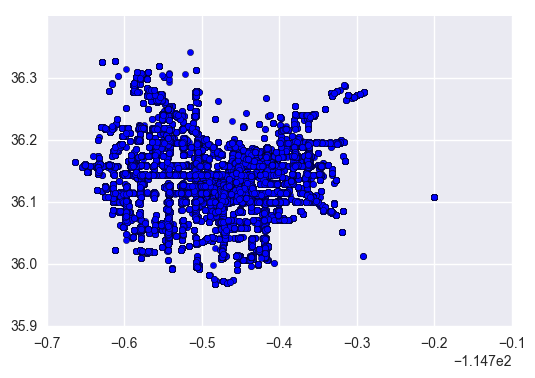

In [23]:
plt.scatter(ycoords, xcoords, c = 'b')

A plot of health inspection reports overlayed on th set of restaurants in the academic dataset. It looks like a fairly good spread.

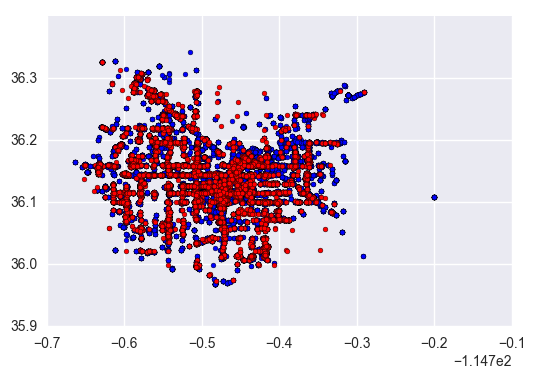

In [123]:
plt.scatter(ycoords, xcoords, c = 'b', s=12)
plt.scatter(long, lat, c='r', s=12)
# plt.scatter(overlap_ycoords, overlap_xcoords, c='', s=12)

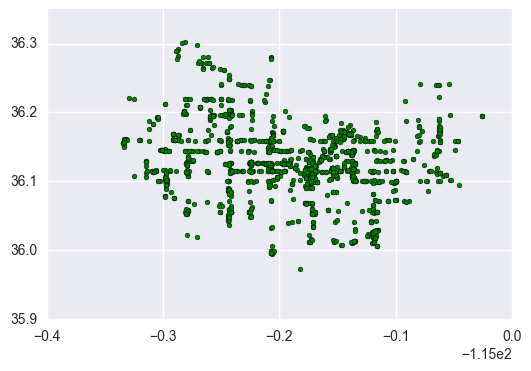

In [124]:
plt.scatter(overlap_ycoords, overlap_xcoords, c='g', s=12)

After visualizing the spread resulting from the plot above, we aggregate the violation data by restaurant.

In [25]:
df_agg = df.groupby('Restaurant Name',as_index=False).agg(lambda x: x.tolist())

In [26]:
dfcategories = df_agg.columns
for x in dfcategories[1:]:
    for y in range(len(df_agg[x])):
        df_agg[x][y] = list(set(df_agg[x][y]))

In [27]:
for x in dfcategories[22:]:
    for y in range(len(df_agg[x])):
        df_agg[x][y] = df_agg[x][y][0]

In [ ]:
df_agg.head()

,Restaurant Name,Serial Number,Permit Number,Location Name,Category Name,Address,City,State,Zip,Current Demerits,...,Inspection Demerits,Inspection Grade,Permit Status,Inspection Result,Violations,Record Updated,Location 1,Coordinates,X,Y
0,#1 HAWAIIAN BARBEQUE,"[DANWBGQY1, DA1280233, DA1444962, DA1282153, D...",[PR0110047],[CHINA DRAGON/#1 HAWAIIAN BARBEQUE],[Restaurant],[5905 S EASTERN Ave 105],[Las Vegas],[Nevada],[89119],[9],...,"[0, 3, 6, 8, 9, 17, 19, 20, 27]","[nan, A, B, C]","[nan, A, B]","['C' Downgrade, 'A' Grade, Compliant, 'B' Down...","[nan, 2112928, 2082112122908290929272956, 2022...","[01/30/2015 04:05:28 PM, 06/09/2015 09:52:01 A...","(36.0820114, -115.119644)","(36.0820114, -115.119644)",36.082,-115.12
1,$5 CAFE,"[DA1510775, DA1280693, DADY9VZ5M, DA1640753]",[PR0017837],[AZTEC INN - $5 CAFE],[Restaurant],[2200 S Las Vegas Blvd],[Las Vegas],[Nevada],[89104-2527],[10],...,"[8, 10, 6]",[A],"[nan, A]","['A' Grade, Compliant]","[202206291029282930, 2022172912, 20229292955, ...","[05/18/2015 12:34:28 PM, 01/11/2016 09:09:42 A...","(36.1459136, -115.1561175)","(36.1459136, -115.1561175)",36.1459,-115.156
2,100 DEGREES HOT POT - DELETED 10/15,"[DA1500853, DA1494935]",[PR0113718],[100 DEGREES HOT POT],[Restaurant],[5600 SPRING MOUNTAIN Rd B],[Las Vegas],[Nevada],[89146],[3],...,"[3, 20]","[A, B]",[nan],"[Compliant, 'B' Downgrade]","[2122911, 20821521829092912292929552956]","[04/29/2015 01:02:30 PM, 04/15/2015 09:57:26 AM]","(36.1265084, -115.2182851)","(36.1265084, -115.2182851)",36.1265,-115.218
3,101 MART SNACK BAR,"[DATYVW3XN, DAV0HMPRO]",[PR0118514],[101 MART],[Snack Bar],[1021 CONVENTION CENTER Dr],[Las Vegas],[Nevada],[89109],[6],...,"[3, 6]",[A],"[nan, A]",['A' Grade],"[291229282955, 2152955]","[04/10/2017 03:52:34 PM, 07/26/2016 02:15:51 PM]","(36.1322288, -115.1553506)","(36.1322288, -115.1553506)",36.1322,-115.155
4,168 Market - Bakery,"[DA0629040, DAHDRCSW0, DA1523505, DA0629041, D...",[PR0021447],[168 Market],[Bakery Sales],[3459 S Jones Blvd],[Las Vegas],[Nevada],[89146-6729],[3],...,"[0, 3, 5, 6, 7, 8, 9, 19]","[A, B]","[nan, nan, nan, nan]","['A' Grade, Compliant, 'B' Downgrade]","[nan, 1964, 217, 2112930, 2152955, 21529092928...","[06/17/2015 10:48:28 AM, 09/25/2013 10:20:16 A...","(36.1265813, -115.2250088)","(36.1265813, -115.2250088)",36.1266,-115.225


In [ ]:
for x in dfcategories[1:22]:
    for y in range(len(df_agg[x])):
        if ((isinstance(df_agg[x][y][0], float) or isinstance(df_agg[x][y][0], str) or isinstance(df_agg[x][y][0], np.int64)) and len(df_agg[x][y])>1 ):
            df_agg[x][y] = ''.join((str(e) +', ') for e in df_agg[x][y])
        else:
            df_agg[x][y] = ''.join(str(df_agg[x][y][0]))

In [ ]:
df_agg.head()

In [ ]:
# create lists for addresses of businesses with violations in order to 
# check for overlap between the Las Vegas Violation set and the yelp set.

violation_addresses = []
overlap = []

for line in df_agg['Address']:
    violation_addresses.append(line.lower())
violation_addresses[:10]

for line in violation_addresses:
    if line in address:
        overlap.append(line)
print(address[:10])
print(overlap[:10])

In [ ]:
print(len(address)) #size of list of Las Vegas Addresses from the Yelp Academic set
print(len(overlap)) #size of addresses in the violation dataset that are in the Yelp dataset
print(len(violation_addresses)) #total addresses in the violation set

In [ ]:
file = 'yelp_academic_dataset_business.json'
business_locations = {}
lv_restaurant_ids = []
with open(file) as f:
    for line in f:
        r_line = json.loads(line)
        business_locations.update({r_line['business_id']:r_line['city']})
        if 'Restaurants' in r_line['categories']:
            lv_restaurant_ids.append(r_line['business_id'])

In [ ]:
len(business_locations)

In [ ]:
len(lv_restaurant_ids)

In [ ]:
# data = []
# file = 'yelp_academic_dataset_review.json'
# # df_reviews = pd.read_json(file, lines=True)
# with open(file) as f:
#     for line in f:
#         r_line = json.loads(line)
#         data.append(r_line)
# # for business in filtered_category_data:
# # #     r_line = json.loads(line)
# #     restaurant_count[business['city']] += 1

before running the next cell, run the pickle.load cell a few cells down

In [ ]:
# read the entire file into a python array
file = 'yelp_academic_dataset_review.json'

# with open(file) as f:
#     for line in f:
#         r_line = json.loads(line)

with open(file, 'r') as f:
    data = f.readlines()

# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
data_json_str = "[" + ','.join(data) + "]"

# now, load it into pandas
df_reviews = pd.read_json(data_json_str)

In [ ]:
df_reviews.head()

In [ ]:
df_reviews['city'] = df_reviews['business_id'].map(business_locations)

In [ ]:
df_reviews.shape

In [ ]:
vegas_cities = ['Las Vegas', 'North Las Vegas', 'N Las Vegas', 'Las Vegas ', 'N. Las Vegas']
df_reviews = df_reviews[df_reviews['city'].isin(vegas_cities)]

In [ ]:
df_reviews.shape

In [ ]:
df_reviews = df_reviews[df_reviews['business_id'].isin(lv_restaurant_ids)]

In [ ]:
df_reviews.shape

run following cell to get df_reviews before anything else

In [ ]:
try:
    with open('df_reviews','rb') as f:
        df_reviews = pickle.load(f)
        
except FileNotFoundError:
    with open('df_reviews','wb') as f:
        pickle.dump(df_reviews, f)

In [ ]:
df_reviews.head()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', min_df=4,max_df=0.8)
dtm = vectorizer.fit_transform(df_reviews['text'])

try:
    with open('stemmed_data','rb') as f:
        stemmed_data = pickle.load(f)
        
except FileNotFoundError:
    stemmed_data = [" ".join(SnowballStemmer("english", ignore_stopwords=True).stem(word)  
        for sent in sent_tokenize(message)
        for word in word_tokenize(sent))
        for message in df_reviews['text']]
    
    with open('stemmed_data','wb') as f:
        pickle.dump(stemmed_data, f)

In [ ]:
print(type(dtm), dtm.shape)
terms = vectorizer.get_feature_names()
print(terms)

In [ ]:
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize



# stemmed_data = news_data.data

In [ ]:
try:
    with open('stemmed_data','rb') as f:
        stemmed_data = pickle.load(f)
        
except FileNotFoundError:
    stemmed_data = [" ".join(SnowballStemmer("english", ignore_stopwords=True).stem(word)  
        for sent in sent_tokenize(message)
        for word in word_tokenize(sent))
        for message in df_reviews['text']]
    
    with open('stemmed_data','wb') as f:
        pickle.dump(stemmed_data, f)

In [ ]:
dtm = vectorizer.fit_transform(stemmed_data)
terms = vectorizer.get_feature_names()
print(terms)

In [ ]:
core_keywords = ['vomit', 'throw up', 'threw up', 'sick', 'diarrhea', 'poison']
keywords = ['vomit', ' vom', 'puke', 'retch', 'threw up', 'throw up', 'poison', 'sick', 'diarrhea', 'barf', 'chuck', 'hurl', 'shits']
count = 0
sick_review = []
for review in df_reviews['text']:
    if any(keyword in review for keyword in keywords):
        sick_review.append(review)
        count += 1
print(count)

In [ ]:
count = 0
core_sick_review = []
for review in df_reviews['text']:
    if any(keyword in review for keyword in core_keywords):
        core_sick_review.append(review)
        count += 1
print(count)

In [ ]:
print(sick_review[:10])

In [ ]:
# # aggregated_reviews = {}
# aggregated_review_texts = {}
# lv_biz_ids = []
# for business_id in df_reviews['business_id'].unique():
# #     aggregated_reviews.update({business_id:list()})
#     aggregated_review_texts.update({business_id:list()})
#     lv_biz_ids.append(business_id)

# for index, row in df_reviews.iterrows():
# #     aggregated_reviews[row['business_id']].append({'date': row['date'], 'review_id': row['review_id'], 'stars': row['stars'], 'text': row['text'], 'user_id': row['user_id'], 'votes': row['votes']})
#     aggregated_review_texts[row['business_id']].append(row['text'])

In [ ]:
try:
    with open('df_agg_revs','rb') as f:
        df_agg_revs = pickle.load(f)
        
except FileNotFoundError:
    aggregated_reviews = {}
    for business_id in df_reviews['business_id'].unique():
        aggregated_reviews.update({business_id:list()})
        aggregated_reviews.update({business_id:[[] for i in range(3)]})

    for index, row in df_reviews.iterrows():
        aggregated_reviews[row['business_id']][0].append(row['stars'])
        aggregated_reviews[row['business_id']][1].append(row['text'])
        aggregated_reviews[row['business_id']][2].append(row['votes'])

    df_agg_revs = pd.DataFrame.from_dict(aggregated_reviews, orient='index')
    df_agg_revs.reset_index(level=0, inplace=True)
    df_agg_revs.columns = ['business_id','stars', 'text', 'votes']
    with open('df_agg_revs','wb') as f:
        pickle.dump(df_agg_revs, f)

In [ ]:
# aggregated_reviews = {}
# for business_id in df_reviews['business_id'].unique():
#     aggregated_reviews.update({business_id:list()})
#     aggregated_reviews.update({business_id:[[] for i in range(3)]})

# for index, row in df_reviews.iterrows():
#     aggregated_reviews[row['business_id']][0].append(row['stars'])
#     aggregated_reviews[row['business_id']][1].append(row['text'])
#     aggregated_reviews[row['business_id']][2].append(row['votes'])

# df_agg_revs = pd.DataFrame.from_dict(aggregated_reviews, orient='index')
# df_agg_revs.reset_index(level=0, inplace=True)
# df_agg_revs.columns = ['business_id','stars', 'text', 'votes']

In [ ]:
df_agg_revs.head()

In [ ]:
# len(lv_biz_ids)

In [ ]:

# sick_scores = {}
# for business_id in df_reviews['business_id'].unique():
#     sick_scores.update({business_id:0})
    
# for biz_id in lv_biz_ids:
#     core_keywords = ['vomit', 'throw up', 'threw up', 'sick', 'diarrhea', 'poison']
#     keywords = ['vomit', ' vom', 'puke', 'retch', 'threw up', 'throw up', 'poison', 'sick', 'diarrhea', 'barf', 'chuck', 'hurl', 'shits']
#     restaurant_sick_score = 0
#     for review in aggregated_review_texts[biz_id]:
#         if any(keyword in review for keyword in core_keywords):
#             restaurant_sick_score += 1
#     sick_scores.update({biz_id: restaurant_sick_score})

In [ ]:
# sick_scores = {}
# updated_sick_scores = {}
# for business_id in df_reviews['business_id'].unique():
#     sick_scores.update({business_id:None})
#     updated_sick_scores.update({business_id:None})

    
# for biz_id in lv_biz_ids:
#     core_keywords = ['vomit', 'throw up', 'threw up', 'sick', 'diarrhea', 'poison']
#     keywords = ['vomit', ' vom', 'puke', 'retch', 'threw up', 'throw up', 'poison', 'sick', 'diarrhea', 'barf', 'chuck', 'hurl', 'shits']
#     keyword_count = [0.0] * len(core_keywords)
#     restaurant_sick_score = 0
#     for review in aggregated_review_texts[biz_id]:
#         if core_keywords[5] in review:
#             keyword_count[5] += 7
#         if core_keywords[4] in review:
#             keyword_count[4] += 3 
#         if core_keywords[2] in review:
#             keyword_count[2] += 5
#         if core_keywords[1] in review:
#             keyword_count[1] += 5
#         if core_keywords[0] in review:
#             keyword_count[0] += 3 
#         if core_keywords[3] in review:
#             keyword_count[3] += 2
#         if any(keyword in review for keyword in core_keywords):
#             restaurant_sick_score += 1
    
#     updated_sick_scores.update({biz_id: sum(keyword_count)})
#     sick_scores.update({biz_id: restaurant_sick_score})
    
# print(keyword_count)

In [ ]:
# updated_fi_scores = {}
# for business_id in df_reviews['business_id'].unique():
# #     sick_scores.update({business_id:None})
#     updated_fi_scores.update({business_id:None})
    
    
# for biz_id in lv_biz_ids:
# #     core_keywords = ['vomit', 'throw up', 'threw up', 'sick', 'diarrhea', 'poison']
# #     core_keywords_scores = [3, 5, 5, 2, 3, 7]
# #     expanded_keywords = ['vomit', ' vom', 'puke', 'retch', 'threw up', 'throw up', 'poison', 'sick', 'diarrhea', 'barf', 'chuck', 'hurl', 'shits']
#     negative_keywords = {'food poison': -0.2, 'diarrhea': -0.16, 'vomit': -0.16,
#                     'threw up': -0.12, 'throw up': -0.1, 'humid': -0.07, 
#                     'employees': -0.02, 'puke': -0.1, 'barf': -0.1}
#     positive_keywords = {'clean': 0.1, 'recommend': 0.08, 'excellent': 0.07,
#                          'affordable': 0.07, 'fuck': 0.05, 'favorite': 0.05,
#                          'fabulous': 0.05, 'professional': 0.04}
# #     keyword_count = [0.0] * len(all_keywords)
#     all_keywords = {**negative_keywords, **positive_keywords}
#     indiv_fi_score = 0
#     for review in aggregated_review_texts[biz_id]:
#         for keyword in all_keywords.keys():
#             count = review.count(keyword)
#             indiv_fi_score += (count * all_keywords[keyword])

# #     updated_sick_scores.update({biz_id: sum(keyword_count)})
#     updated_fi_scores.update({biz_id: indiv_fi_score})
    
# # print(keyword_count)

In [ ]:
# updated_fi_scores['Q3klrPwtiLO5WS2LWXIvpA']

In [ ]:
def fi_scorer(reviews, votes):
    negative_keywords = {'food poison': -0.22, 'diarrhea': -0.18, 'vomit': -0.18,
                    'threw up': -0.14, 'throw up': -0.12, 'humid': -0.09, 
                     'puke': -0.12, 'barf': -0.12}
    positive_keywords = {'clean': 0.1, 'recommend': 0.08, 'excellent': 0.07,
                         'affordable': 0.07, 'favorite': 0.05,
                         'fabulous': 0.05, 'professional': 0.04}
    all_keywords = {**negative_keywords, **positive_keywords}
#     indiv_fi_score = 0
    fi_scores = []
    for idx, review in enumerate(reviews):
        review_fi_score = 0
        vote_dict = votes[idx]
        total_votes = sum(vote_dict.values())
        if total_votes != 0:
            vote_mult = ((1.5 * vote_dict['useful']) + 
                         (1.2 *vote_dict['cool']) + 
                         (1.02 * vote_dict['funny']))
        else:
            vote_mult = 1
        
        for keyword in all_keywords.keys():
            count = review.count(keyword)
#             fi_scores.append(count * all_keywords[keyword])
            review_fi_score += (count * all_keywords[keyword])
        
        review_fi_score *= vote_mult
        fi_scores.append(review_fi_score)
    return fi_scores
#     return indiv_fi_score

In [ ]:
df_agg_revs['fi_scores'] = df_agg_revs.apply(lambda row: fi_scorer(reviews = row['text'], votes = row['votes']), axis = 1)

In [ ]:
df_agg_revs.head()

In [ ]:
def averager(values):
    return (sum(values)/len(values))

In [ ]:
df_agg_revs['fi_scores_avg'] = df_agg_revs['fi_scores'].map(averager)

In [ ]:
df_agg_revs.head()

In [ ]:
df_agg_revs.shape

divide by number of reviews? because although a restaurant that has more instances of keywords may have a higher score, but what if only a minute fraction of those reviews report cases of food poisoning?

In [ ]:
df_fi_sorted = df_agg_revs.sort(columns = 'fi_scores_avg', axis = 0)
df_fi_sorted.reset_index(inplace = True)

In [ ]:
df_fi_sorted.head()

In [ ]:
len(df_fi_sorted.ix[0, 'text'])

In [ ]:
df_fi_sorted.ix[1, 'votes']

In [ ]:
df_fi_sorted.ix[1, 'fi_scores']

In [ ]:
df_fi_sorted.ix[1, 'text'][2]

In [ ]:
with open('df_fi_sorted','wb') as f:
    pickle.dump(df_fi_sorted, f)